# Clustering

Für das Clustering wirst du wieder das `digits`-Datenset nutzen und auch hier intensiv mit Visualisierungen arbeiten.

## Datenset laden

Diesen Teil kennst du schon:

In [1]:
from sklearn import datasets
digits = datasets.load_digits()

Wie gewohnt konvertierst du die Daten in einen `DataFrame`:

In [2]:
import pandas as pd
df = pd.DataFrame(digits["data"], columns=digits["feature_names"])
df["class"] = [digits["target_names"][target] for target in digits["target"]]

Du erkennst die Anzahl der Samples und die Features (`target` zählt nicht als Feature).

## K-Means

Zuerst probierst du das *K-Means*-Verfahren zum Clustering aus. *K-Means* benötigt die Anzahl der Cluster als Parameter, probiere es zuerst mit der richtigen Anzahl `10`.

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
km.fit(digits["data"])

KMeans(n_clusters=10)

Das Clustering selbst wird durch die `fit`-Methode durchgeführt. Die Daten selbst werden nicht verändert, daher fehlt hier das `transform`. Nach dem Aufruf steht dir im Objekt eine Variable `labels_` zur Verfügung. Für jeden Datensatz wird hier die Nummer des Clusters angegeben.

Nachdem die Nummerierung beliebig ist, kannst du nicht davon ausgehen, dass die Nummer der Zahl entspricht. Stattdessen kannst du aber visualisieren, wie häufig eine Zahl (`target`) in genau einen Cluster gefallen ist.

Dazu baust du eine Matrix auf:

In [4]:
import numpy as np
counts = np.zeros((10, 10))
for i in range(len(digits["target"])):
    counts[digits["target"][i]][km.labels_[i]] += 1

Am einfachsten kannst du das als *Heatmap* visualisieren. In den Zeilen steht dabei die echte Zahl, die Spalten sind die erkannten Cluster. Pro Zeile sollte also immer nur ein Wert "aufleuchten". Im Bereich des Überwachten Lernens wirst du eine ähnliche Konstruktion später als *Confusion Matrix* kennenlernen.

<AxesSubplot:>

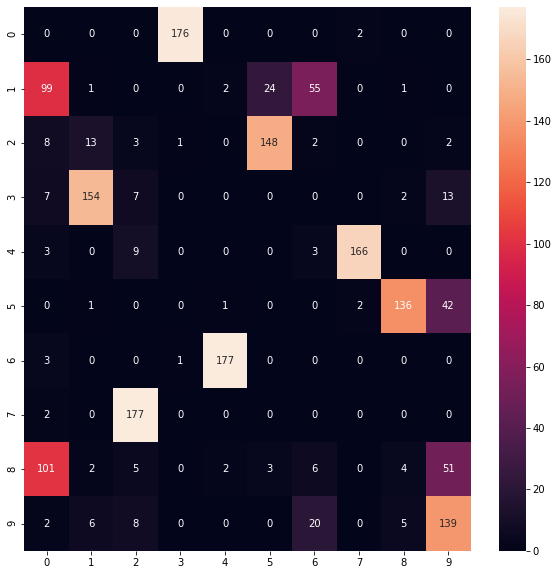

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.heatmap(counts, annot=True, fmt=".0f")

Bei `0`, `2`,  `3`,  `4`,  `6` und `7` klappt das ganz gut, bei den anderen eher nicht. Wenn du möchtest, kannst du dir das auch nochmal mit UMAP in zwei Dimensionen anzeigen lassen. Diesmal sind die Farben nicht die Ziffern, sondern die Cluster:

In [ ]:
!pip install umap-learn[parametric_umap]

Zum Glück ist der Aufruf aber sehr ähnlich (es erbt einige Klassen von `scikit-learn`):

<AxesSubplot:xlabel='x', ylabel='y'>

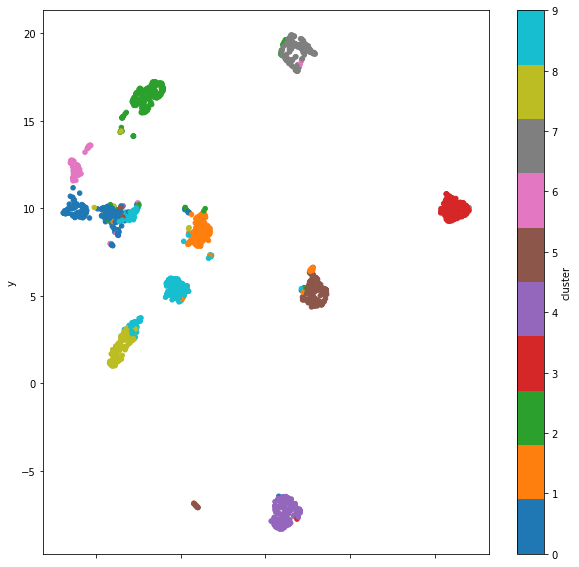

In [6]:
import umap
umap2 = umap.UMAP(n_components=2, random_state=42)
udf = pd.DataFrame(umap2.fit_transform(digits["data"], ), columns=["x", "y"])
udf["target"] = digits["target"]
udf["cluster"] = km.labels_
udf.plot.scatter(x='x', y='y', c="cluster", figsize=(10,10), cmap="tab10")

Ein bisschen Durcheinander hat der Algorithmus schon gebaut. Vergleiche mit den echten Ziffern:

<AxesSubplot:xlabel='x', ylabel='y'>

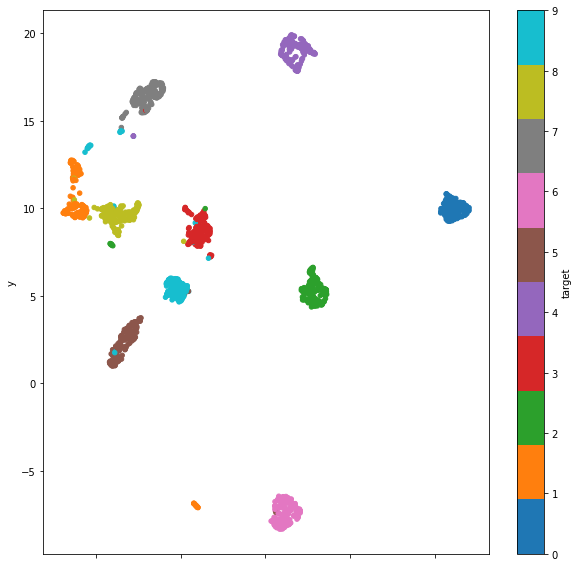

In [7]:
udf.plot.scatter(x='x', y='y', c="target", figsize=(10,10), cmap="tab10")

Das sieht sauberer aus!

Wie du im letzten Teil gesehen hast, ist es oft günstiger, zuerst die Dimensionsreduktion durchzuführen und anschließend mit dem Machine Learning zu beginnen. Das kannst du hier sehr einfach machen, indem du das Clustering auf die reduzierten Daten anwendest:

<AxesSubplot:xlabel='x', ylabel='y'>

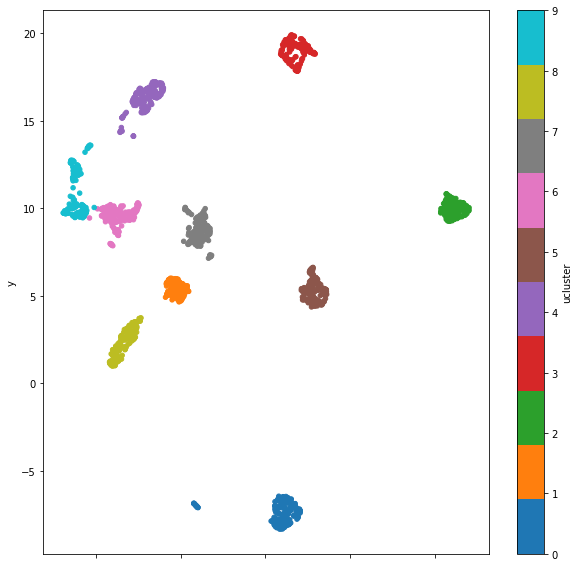

In [8]:
kmu = KMeans(n_clusters=10)
kmu.fit(udf[["x", "y"]])
udf["ucluster"] = kmu.labels_
udf.plot.scatter(x='x', y='y', c="ucluster", figsize=(10,10), cmap="tab10")

Schau dir zum Vergleich jetzt nochmal an, ob die Zahlen in die richtigen Cluster einsortiert wurden:

<AxesSubplot:>

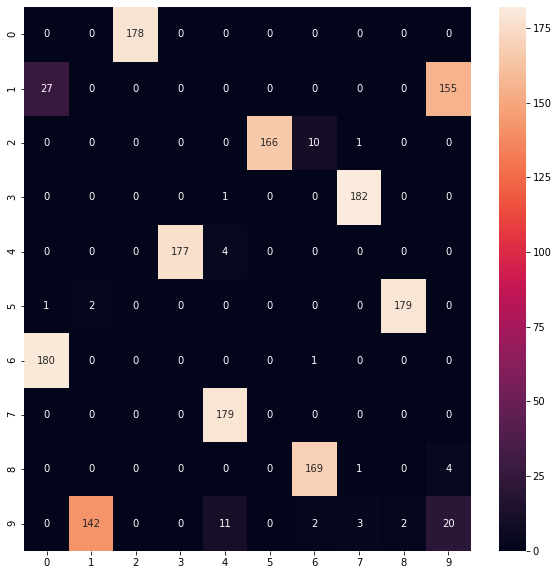

In [9]:
ucounts = np.zeros((10, 10))
for i in range(len(digits["target"])):
    ucounts[digits["target"][i]][kmu.labels_[i]] += 1
plt.figure(figsize=(10, 10))
sns.heatmap(ucounts, annot=True, fmt=".0f")

Das sieht deutlich besser aus. Die Dimensionsreduktion vor dem Clustering hat extrem geholfen!

Wie du oben gesehen hast, musstest du die richtige Anzahl der Cluster *raten*. Probier es auch mal mit anderen Anzahlen aus! Später wirst du Methoden kennenlernen, die dir Qualitätskriterien zur Verfügung stellen. Anhand derer kannst du entscheiden, welches die richtige Anzahl an Clustern ist.

## Birch Clustering

Die Birch-Methode ist sehr ähnlich zu K-Means, auch wenn das interne Berechnungsverfahren etwas anders funktioniert. Dank des einheitlichen Interfaces von `scikit-learn` kannst du es einfach ersetzen. Versuch es zunächst mit den originalen Daten:

In [10]:
from sklearn.cluster import Birch
birch = Birch(n_clusters=10)
birch.fit(digits["data"])

Birch(n_clusters=10)

Du kannst wieder die gleichen Schritte wie bei `KMeans` anwenden:

<AxesSubplot:>

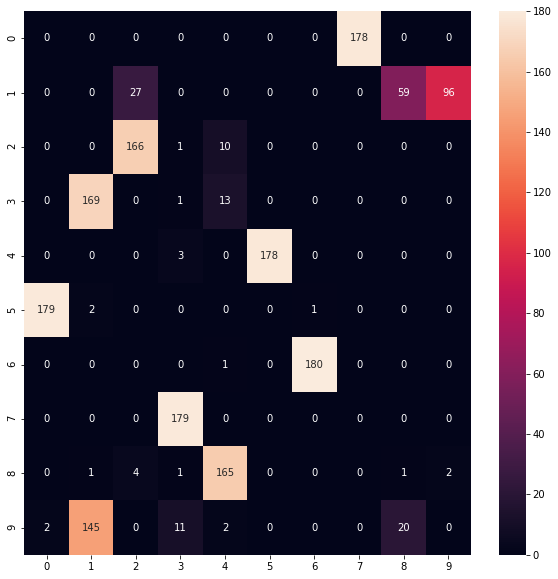

In [11]:
bcounts = np.zeros((10, 10))
for i in range(len(digits["target"])):
    bcounts[digits["target"][i]][birch.labels_[i]] += 1
    
plt.figure(figsize=(10, 10))
sns.heatmap(bcounts, annot=True, fmt=".0f")

Das hat sehr viel besser funktioniert! Nur bei `1` hatte der Algorithmus Schwierigkeiten.

# Mean Shift

Der Mean-Shift-Algorithmus funktioniert anders und benötigt keine Anzahl von Clustern als Vorgabe, sondern liefert die als Ergebnis. Probier es aus:

In [12]:
from sklearn.cluster import MeanShift
ms = MeanShift()
ms.fit(digits["data"])

MeanShift()

Nun kannst du ermitteln, wie viele Cluster der Algorithmus entdeckt hat. Alle notwendigen Informationen sind im `labels_`-Feld bereits enthalten:

In [13]:
np.unique(ms.labels_, return_counts=True)

(array([0]), array([1797]))

Leider hat `MeanShift` nur einen Cluster entdeckt. Auch hier kannst du wieder mit den dimensionsreduzierten Daten arbeiten:

In [14]:
msu = MeanShift()
msu.fit(udf[["x", "y"]])
np.unique(msu.labels_, return_counts=True)

(array([0, 1, 2]), array([1068,  521,  208]))

Das hat nun besser funktioniert, aber genügt unseren Ansprüchen noch immer nicht. `MeanShift` funktioniert häufig nicht zufriedenstellend.

## DBSCAN

`DBSCAN` ist ein dichtebasiertes Verfahren. Cluster werden dann als zusammenhängend interpretiert, wenn die Dichte der Punkte in ihnen hoch ist, die Dichte zwischen den Clustern aber niedrig. `DBSCAN` liefert immer auch Punkte zurück, die zu keinem Cluster gehören - die sind dann dem "Cluster" `-1` zugeordnet. Der Aufruf ist wieder wie gewohnt:

In [15]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN()
dbs.fit(digits["data"])
np.unique(dbs.labels_, return_counts=True)

(array([-1]), array([1797]))

Das hat gar nicht funktioniert. `DBSCAN` ist vor allem für niedrigere Dimensionen geeignet:

In [16]:
dbsu = DBSCAN()
dbsu.fit(udf[["x", "y"]])
np.unique(dbsu.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([  4, 178, 331,  10, 174, 177, 144, 181, 168, 166, 181,  11,  20,
         12,  27,  13]))

Das ist schon deutlich besser, wenn auch noch nicht richtig gut. Schau dir an, wie sich die Cluster auf die Zahlen verteilen:

<AxesSubplot:>

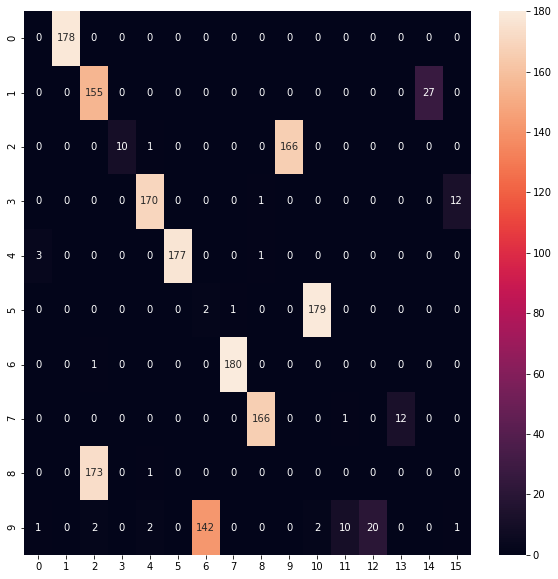

In [17]:
dcounts = np.zeros((10, 16))
for i in range(len(digits["target"])):
    dcounts[digits["target"][i]][dbsu.labels_[i]+1] += 1
    
plt.figure(figsize=(10, 10))
sns.heatmap(dcounts, annot=True, fmt=".0f")

Wie du siehst, sind viele Ziffern gut zugeordnet worden. Allerdings ist der Algorithmus eher "zu streng" gewesen und hat unsauber geschriebene Ziffern anderen Cluster zugeordnet.

## Richtiger Clustering-Algorithmus ist entscheidend

Du hast in diesem Notebook unterschiedliche Cluster-Algorithmen kennengelernt. Wie du gemerkt hast, ist es nicht nur entscheidend, den richtigen Algorithmus zu wählen, sondern auch die Dimensionen vorher entsprechend zu reduzieren.